In [1]:
# Works on numpy 1.24.2, matplotlib 3.7.1
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Author of the code: Russell Kunes https://github.com/russellkune/SIR
# Commented by: Kinane Habra
# Package dependence: numpy

class SIR1:
    def __init__(self, K=2, H=10, bins=None):
        # K: Number of dimensions for the EDR-space
        # H: Number of slices to divide the response variable
        # bins: Specific bin edges for slicing; if None, bins are equally spaced
        self.K = K
        self.H = H
        self.bins = bins

    def fit(self, X, Y):
        # Fit the SIR model to the data
        # X: Predictor variables
        # Y: Response variable

        # Step 1: (Implicit) Standardize X is handled in covariance matrix calculation

        # n: Number of observations, p: Number of predictors
        n = X.shape[0]
        p = X.shape[1]

        # x_bar: Sample mean of X
        x_bar = np.mean(X, axis=0)

        # Step 2: Divide the range of Y into S slices and compute number of observations per slice
        if self.bins is None:
            n_h, bins = np.histogram(Y, bins=self.H)
        else:
            n_h, bins = np.histogram(Y, bins=self.bins)

        # Assign each observation to a slice
        assignments = np.digitize(Y, bins)

        # Ensure last observation is within the last slice
        assignments[np.argmax(assignments)] -= 1

        # M: Will store the sum of within-slice covariance matrices
        M = np.zeros((p, p))

        # Step 3: Loop through slices and compute mean of X for each slice
        for i in range(len(n_h)):
            h = n_h[i]  # Number of observations in slice i
            if h != 0:
                x_h_bar = np.mean(X[assignments == i + 1], axis=0)
            else:
                x_h_bar = np.zeros(p)

            # Standardized slice mean
            x_std = x_h_bar - x_bar

            # Update M with the outer product of the standardized slice mean
            M += float(h) * np.outer(x_std, x_std)

        # Step 4: Calculate the covariance matrix estimate for the inverse regression curve
        M = float(n)**(-1) * M
        self.M = M

        # Step 5 & 6: Eigendecomposition to find EDR directions
        # V: Scaled version of M to account for variance in X
        cov = np.cov(X.T)
        V = np.dot(linalg.inv(cov), M)

        # Find eigenvalues and eigenvectors of V
        eigenvalues, eigenvectors = linalg.eig(V)

        # Sort eigenvalues and eigenvectors
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        # Select the first K eigenvectors as the EDR directions
        beta = eigenvectors[:, :self.K]
        self.beta = beta
        self.eigenvalues = eigenvalues
        return

    def transform(self, X_to_predict):
        # Project new data onto the EDR space using the beta coefficients
        beta = self.beta
        return np.dot(X_to_predict, beta)

In [3]:
np.random.seed(2727)
n = 300                                    # number of observations
ns = 20                                    # number of elements in each slice
h = np.floor(n / ns)                       # number of slices
x = np.column_stack((np.random.randn(n),   # n x 3 matrix, the explanatory variable
                     np.random.randn(n),
                     np.random.randn(n)))
e = np.random.randn(n)                     # n vector, the noise variable
b2 = np.array([1, -1, -1])                 # projection vector
b1 = np.array([1, 1, 1])                   # projection vector

In [4]:
y = x@b1 + (x@b1)** 3 + 4 * (x@b2) ** 2 + e  # n vector, the response variable

In [5]:
edr = SIR1(K = 3, H = int(h))
edr.fit(x,y)

In [6]:
f = edr.beta  # matrix of the estimated EDR-directions
g = edr.eigenvalues # vector of eigenvalues

In [7]:
# matrices for the true indices and the true responses
m1 = np.column_stack((x@b1, y))
m2 = np.column_stack((x@b2, y))

In [8]:
# Sort m1 and m2 based on the first column
m1 = m1[m1[:, 0].argsort()]
m2 = m2[m2[:, 0].argsort()]

In [9]:
sg = sum(g)
g2 = g / sg
psi = np.array([g2[0], g2[0] + g2[1], g2[0] + g2[1] + g2[2]])

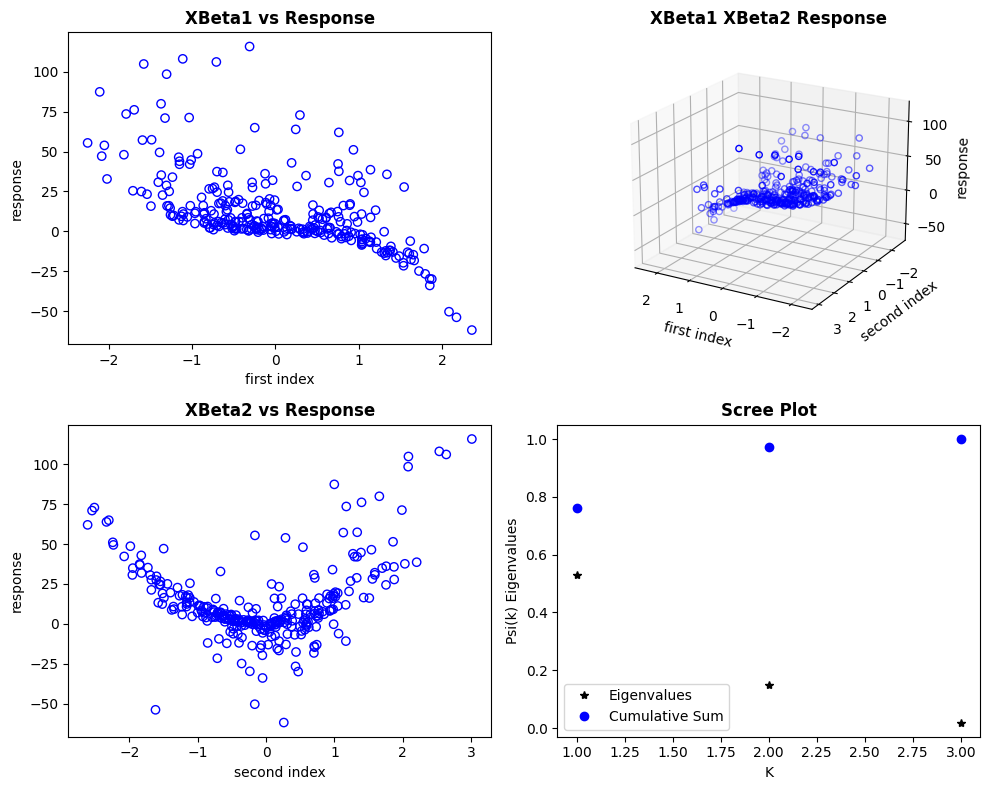

In [10]:
# Compute projections
p11 = np.column_stack((x @ f[:, 0], y))
p21 = np.column_stack((x @ f[:, 1], y))
p12 = np.column_stack((x @ f[:, 0], x @ f[:, 1], y))

# Plotting
fig = plt.figure(figsize=(10, 8))

# First subplot
ax1 = fig.add_subplot(221)
ax1.scatter(p11[:, 0], p11[:, 1], color="blue", facecolors='none')
ax1.set_xlabel("first index")
ax1.set_ylabel("response")
ax1.set_title("XBeta1 vs Response", fontweight='bold')

# Second subplot
ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(p12[:, 0], p12[:, 1], p12[:, 2], color="blue", facecolors='none')
ax2.set_xlabel("first index")
ax2.set_ylabel("second index")
ax2.set_zlabel("response")
ax2.set_title("XBeta1 XBeta2 Response", fontweight='bold')
ax2.view_init(elev=20, azim=120) # Adjust to get the desired view

# Third subplot
ax3 = fig.add_subplot(223)
ax3.scatter(p21[:, 0], p21[:, 1], color="blue", facecolors='none')
ax3.set_xlabel("second index")
ax3.set_ylabel("response")
ax3.set_title("XBeta2 vs Response", fontweight='bold')


# Fourth subplot (Scree plot)
ax4 = fig.add_subplot(224)
i = np.array([1, 2, 3])
ax4.plot(i, g, '*', color='k', label='Eigenvalues')
ax4.plot(i, psi, 'o', color='b', label='Cumulative Sum')
ax4.set_xlabel("K")
ax4.set_ylabel("Psi(k) Eigenvalues")
ax4.set_title("Scree Plot", fontweight='bold')
ax4.legend()


plt.tight_layout()
plt.show()

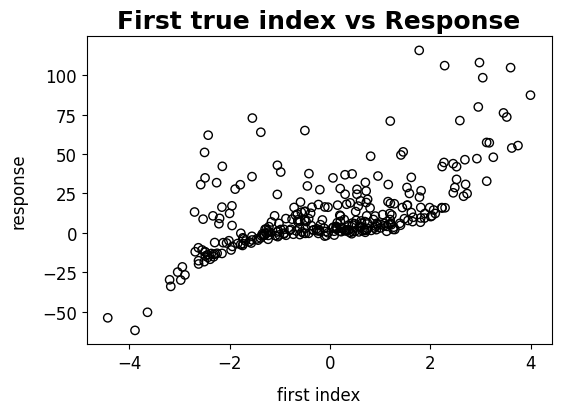

In [11]:
# Fifth figure
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(m1[:, 0], m1[:, 1], edgecolors='black', facecolors='none')
ax.set_xlabel("first index", fontsize=12, labelpad=10)
ax.set_ylabel("response", fontsize=12, labelpad=10)
ax.set_title("First true index vs Response", fontsize=18, fontweight='bold')
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.show()

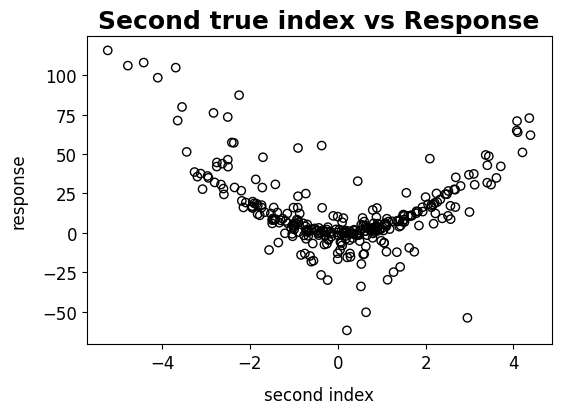

In [12]:
# Sixth figure
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(m2[:, 0], m2[:, 1], edgecolors='black', facecolors='none')
ax.set_xlabel("second index", fontsize=12, labelpad=10)
ax.set_ylabel("response", fontsize=12, labelpad=10)
ax.set_title("Second true index vs Response", fontsize=18, fontweight='bold')
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.show()